# new Connector Features.
## Heuristic Max Network

In [1]:
import numpy as np

from konnektor.utils.toy_data import build_random_dataset

toy_data = build_random_dataset(10)
compounds, genMapper, genScorer = toy_data


In [2]:
from konnektor import HeuristicMaximalNetworkPlanner

planner = HeuristicMaximalNetworkPlanner(mapper=genMapper(), scorer=genScorer(), n_samples=2)
heu_max_net = planner(compounds)


In [3]:
from konnektor import MaximalNetworkPlanner

planner = MaximalNetworkPlanner(mapper=genMapper(), scorer=genScorer())
max_net = planner(compounds)


In [4]:
n_compounds = len(compounds)
n_expected_max_net = sum(range(len(compounds)))

n_max_net =  len(max_net.edges)
n_heu_max_net =  len(heu_max_net.edges)

n_compounds, n_expected_max_net, n_max_net, n_heu_max_net

(9, 36, 36, 18)

## Charge Scorer

In [30]:
import numpy as np

def scor(chargeA, chargeB):
    def classify(x):
        if x >0:
            return 1
        elif x==0:
            return 2
        else:
            return 3
    
    charge_class_change_punishment_factor=0.1
    smoothing_factor = 3.5
    if classify(chargeA)==classify(chargeB):
        dist= min(1, abs((chargeA-chargeB)/smoothing_factor))
    elif abs(classify(chargeA)-classify(chargeB)) == 1:
        dist= min(1, charge_class_change_punishment_factor+abs((chargeA-chargeB)/smoothing_factor))
    else:         
        dist= min(1, 2*charge_class_change_punishment_factor+abs((chargeA-chargeB)/smoothing_factor))

    return 1-dist

from gufe import AtomMapping
def score_charge(atom_mapping:AtomMapping):
    chargeA = Chem.GetFormalCharge(atom_mapping.componentA.to_rdkit())
    chargeB = Chem.GetFormalCharge(atom_mapping.componentB.to_rdkit())
    return scor(chargeA=chargeA, chargeB=chargeB)
    
    


(-0.1, 1.1)

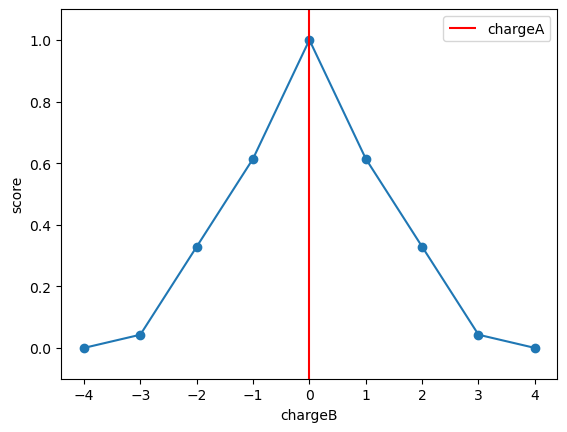

In [6]:
from matplotlib import pyplot as plt

chargeA = 0
chargeB = np.linspace(-4, 4, 9)
scores = list(map(lambda x: scor(chargeA, x), chargeB))

plt.plot(chargeB, scores, marker="o")
plt.vlines(x=chargeA, ymin=-2, ymax=6, color="red", label="chargeA")
plt.xlabel('chargeB')
plt.ylabel("score")
plt.legend()
plt.ylim([-0.1,1.1])

(-0.1, 1.1)

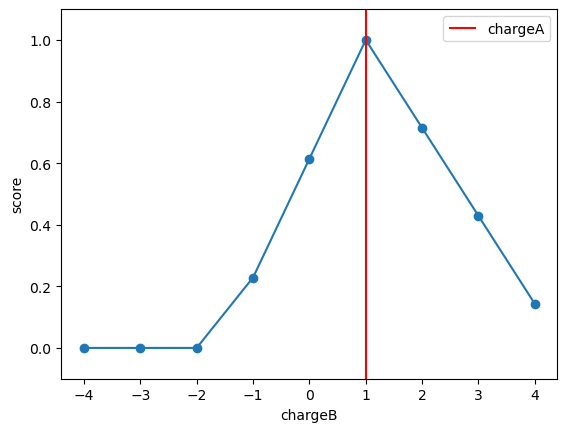

In [7]:
from matplotlib import pyplot as plt

chargeA = 1
chargeB = np.linspace(-4, 4, 9)
scores = list(map(lambda x: scor(chargeA, x), chargeB))

plt.plot(chargeB, scores, marker="o")
plt.vlines(x=chargeA, ymin=-2, ymax=6, color="red", label="chargeA")
plt.xlabel('chargeB')
plt.ylabel("score")
plt.legend()
plt.ylim([-0.1,1.1])


(-0.1, 1.1)

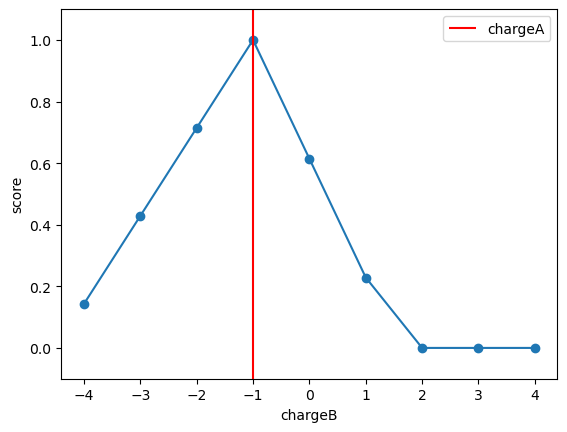

In [8]:
from matplotlib import pyplot as plt

chargeA = -1
chargeB = np.linspace(-4, 4, 9)
scores = list(map(lambda x: scor(chargeA, x), chargeB))

plt.plot(chargeB, scores, marker="o")
plt.vlines(x=chargeA, ymin=-2, ymax=6, color="red", label="chargeA")
plt.xlabel('chargeB')
plt.ylabel("score")
plt.legend()
plt.ylim([-0.1,1.1])


(-0.1, 1.1)

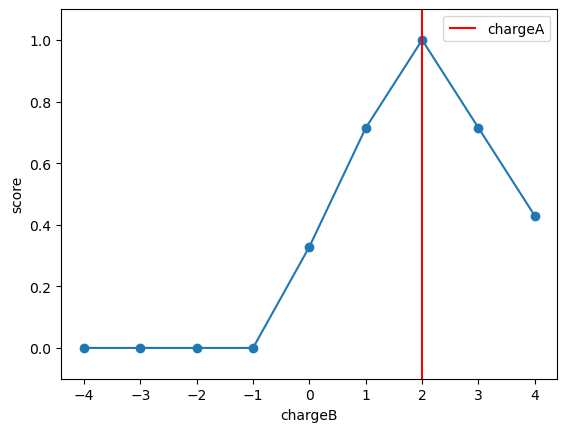

In [10]:
from matplotlib import pyplot as plt

chargeA = 2
chargeB = np.linspace(-4, 4, 9)
scores = list(map(lambda x: scor(chargeA, x), chargeB))

plt.plot(chargeB, scores, marker="o")
plt.vlines(x=chargeA, ymin=-2, ymax=6, color="red", label="chargeA")
plt.xlabel('chargeB')
plt.ylabel("score")
plt.legend()
plt.ylim([-0.1,1.1])


## Dutch Bridges

In [25]:
from typing import Union
from scikit_mol.fingerprints import FpsTransformer

from rdkit.Chem import rdEHTTools

class ChargeTransformer(FpsTransformer):
    def __init__(self, parallel: Union[bool, int] = False
                 ):
        """Calculates the RDKit FormalCharge

        Parameters
        ----------
        
        """
        super().__init__(parallel = parallel)
        self.nBits=1

    @property
    def fpSize(self):
        return self.nBits

    #Scikit-Learn expects to be able to set fpSize directly on object via .set_params(), so this updates nBits used by the abstract class
    @fpSize.setter
    def fpSize(self, fpSize):
        self.nBits = fpSize

    def _mol2fp(self, mol):
        pass
    
    def _transform_mol(self, mol):
        charge = Chem.GetFormalCharge(mol)
        return np.array([charge])

In [26]:
from gufe import SmallMoleculeComponent
from rdkit import Chem
mols = list(Chem.SDMolSupplier("./cligands.sdf", removeHs=False))
com = [SmallMoleculeComponent.from_rdkit(m) for m in mols]

In [27]:
#Test charge Cluster
from sklearn.cluster import DBSCAN
from konnektor.network_tools.cluster_molecules import CompoundDiversityClustering

clusterer = CompoundDiversityClustering(featurize=ChargeTransformer(), 
                                        cluster=DBSCAN())
clusters = clusterer.cluster_compounds(compounds=com)


In [14]:
clusters

{0: [SmallMoleculeComponent(name=lig_CHEMBL3265000),
  SmallMoleculeComponent(name=lig_CHEMBL3265001),
  SmallMoleculeComponent(name=lig_CHEMBL3264998),
  SmallMoleculeComponent(name=lig_CHEMBL3264995),
  SmallMoleculeComponent(name=lig_CHEMBL3264997),
  SmallMoleculeComponent(name=lig_CHEMBL3264994)],
 1: [SmallMoleculeComponent(name=lig_CHEMBL3265002),
  SmallMoleculeComponent(name=lig_CHEMBL3264996),
  SmallMoleculeComponent(name=lig_CHEMBL3265003),
  SmallMoleculeComponent(name=lig_CHEMBL3265008),
  SmallMoleculeComponent(name=lig_CHEMBL3265004),
  SmallMoleculeComponent(name=lig_CHEMBL3265009),
  SmallMoleculeComponent(name=lig_CHEMBL3265010),
  SmallMoleculeComponent(name=lig_CHEMBL3265005),
  SmallMoleculeComponent(name=lig_CHEMBL3264999),
  SmallMoleculeComponent(name=lig_CHEMBL3265034),
  SmallMoleculeComponent(name=lig_CHEMBL3265011),
  SmallMoleculeComponent(name=lig_CHEMBL3265033),
  SmallMoleculeComponent(name=lig_CHEMBL3265006),
  SmallMoleculeComponent(name=lig_CHEMBL326

In [31]:
from openfe.setup import lomap_scorers, KartografAtomMapper

from konnektor.network_planners import DiversityNetworkPlanner, StarLigandNetworkPlanner


combined_scorer = lambda x: (2*score_charge(x)+lomap_scorers.default_lomap_score(x))/3
network_planner = DiversityNetworkPlanner(mapper=KartografAtomMapper(), scorer=combined_scorer, node_featurizer=ChargeTransformer(), clustering=DBSCAN(), sub_network_planners=[StarLigandNetworkPlanner])


In [32]:
dutch_network = network_planner(com)

Build Cluster Networks: 100%|██████████| 2/2 [01:00<00:00, 30.13s/it]


In [33]:
len(dutch_network.nodes), len(com), len(dutch_network.edges)

(44, 44, 45)

In [19]:
from konnektor.visualization  import draw_network_widget

draw_network_widget(dutch_network);

interactive(children=(Dropdown(description='layout', index=6, options=('dagre', 'cola', 'breadthfirst', 'circu…